# DENOISING DIFFUSION IMPLICIT MODELS

The core idea of Denoising Diffusion Models (DDMs) is to train a model to generate images by iteratively corrupting an image with noise over a series of steps and then learning to reverse this process. The process consists of two phases:

<img src="./images/ddim1.png" width="450" />

<div></div>
1.  $q$ - Forward Noising Process (Diffusion): The original image ($X_t$) is gradually corrupt over a large number of steps ($T=1000$) by adding small amounts of noise from standard Gausian distribution ($ \mathcal{N}$) at each step, transforming it into pure noise after all steps being done. This process is designed to be gradual and reversible.

<div style="font-size:22px">
$
  \mathbf{x}_t = \sqrt{\bar{ \alpha_t}} \mathbf{x}_0 + \sqrt{1 - \bar{\alpha_t}} \boldsymbol{\epsilon}, \quad \boldsymbol{\epsilon} \sim \mathcal{N}(0, \mathbf{I})
$
</div>
Explanation:

- $\mathbf{x}_t$: Noisy version of the original data at step tt.
- $\mathbf{x}_0$: Original clean data (e.g., an image).
- $\bar{\alpha_t}$: Noise scheduling parameter, controlling the amount of noise added at each step.
- $\epsilon$: Gaussian noise sampled from N(0,I)N(0,I).
    
2. Reverse Process (Denoising): The model learns to reconstruct the image by reversing the noising process step by step. Starting from a sample of random noise, the model denoises iteratively, learning to recover an increasingly less noisy image until it reconstructs a realistic image at the end of the process.

Over the course of training, the model learns how to map noisy data at any intermediate step back toward the clean image. Once trained, the model can generate new images by sampling random noise from a normal distribution and denoising it step by step, effectively generating realistic images from noise.

## Imports

In [1]:
import datetime
from tensorflow.keras import (
    utils,
    layers,
    activations,
    models,
    metrics,
    optimizers,
    losses,
    callbacks
)
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import numpy as np

2024-11-21 21:10:55.909583: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-21 21:10:55.938843: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-21 21:10:55.938879: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-21 21:10:55.940063: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-21 21:10:55.945409: I tensorflow/core/platform/cpu_feature_gua

## Global Settings

In [2]:
flowers_path='./datasets/flowers/'
tensorboard_log_dir= './logs/ddim/flowers/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
checkpoint_dir= './logs/ddim/flowers/checkpoints/'

## Functions

In [3]:
def preprocess_flowers(img):
    img= tf.cast(img,'float32') / 255.0
    return img

def sample_batch(dataset):
    batch= dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch= batch[0]

    return batch.numpy()

def display_sample(images, n=10, size=(20,3), cmap='gray_r', as_type='float32'):
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images= (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _= plt.subplot(1,n,i+1) # (n, 1, i + 1) Arrange as n rows and 1 column
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis('off')

    plt.show()

def linear_diffusion_schedule(diffusion_times):
    min_rate= 1e-4
    max_rate= .02
    betas= min_rate + diffusion_times * (max_rate - min_rate)
    alphas= 1- betas
    alphas_bar= tf.math.cumprod(alphas)
    
    signal_rates= tf.sqrt(alphas_bar)
    noise_rates= tf.sqrt(1 - alphas_bar)

    return noise_rates, signal_rates

def cosine_diffusion_schedule(diffusion_times):
    signal_rates= tf.cos(diffusion_times * math.pi /2)
    noise_rates= tf.sin(diffusion_times * math.pi /2)

    return noise_rates, signal_rates

def offset_cos_diffusion_schedule(diffusion_times):
    min_signal_rate= .02
    max_signal_rate= .95
    start_angle= tf.acos(max_signal_rate)
    end_angle= tf.acos(min_signal_rate)
    diffusion_angles= start_angle + diffusion_times * (end_angle - start_angle)

    signal_rates= tf.cos(diffusion_angles)
    noise_rates= tf.sin(diffusion_angles)

    return noise_rates, signal_rates

from keras.saving import register_keras_serializable
@register_keras_serializable(package="Custom", name="sin_embeddings")
def sin_embeddings(x):
    freq= tf.exp(
        tf.linspace(
            tf.math.log(1.0),
            tf.math.log(1000.0),
            32 // 2
        )
    )
    angular_speeds= 2.0 * math.pi * freq
    embeddings= tf.concat(
        [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=3
    )
    return embeddings

def resid_block(width):
    def apply(x):
        input_width= x.shape[3]

        if input_width == width:
            residual= x
        else:
            residual= layers.Conv2D(width, kernel_size=1)(x)

        x= layers.BatchNormalization(center=False, scale=False)(x)
        x= layers.Conv2D(width, kernel_size=3, padding='same', activation= activations.swish)(x)
        x= layers.Conv2D(width, kernel_size=3, padding='same')(x)
        x= layers.Add()([x, residual])

        return x

    return apply

def down_block(width, block_depth):
    def apply(x):
        x, skips= x

        for _ in range(block_depth):
            x= resid_block(width)(x)
            skips.append(x)

        x= layers.AveragePooling2D(pool_size=2)(x)

        return x

    return apply

def up_block(width, block_depth):
    def apply(x):
        x, skips= x
        x= layers.UpSampling2D(size=2, interpolation='bilinear')(x)
    
        for _ in range(block_depth):
            x= layers.Concatenate()([x, skips.pop()])
            x= resid_block(width)(x)

        return x

    return apply

def spherical_interpolation(a,b,t):
    return np.sin(t * math.pi / 2) * a + np.cos(t * math.pi / 2) * b

## INIT DATASET

### Load data

In [4]:
%%time
# ~ 20 sec.
train_data= utils.image_dataset_from_directory(
    flowers_path + 'dataset/all_in_one',
    labels=None,
    image_size=(64,64),
    batch_size=None,
    shuffle=True,
    seed=42,
    interpolation='bilinear'
)

Found 8189 files.


2024-11-21 21:11:18.125376: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-21 21:11:18.150779: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-21 21:11:18.150824: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-21 21:11:18.154524: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-21 21:11:18.154570: I external/local_xla/xla/stream_executor

CPU times: user 1.04 s, sys: 966 ms, total: 2.01 s
Wall time: 21.1 s


### Configure dataset

In [5]:
%%time
# ~ 17ms
train= train_data.map(lambda x: preprocess_flowers(x))
train= train.repeat(5)
train= train.batch(64, drop_remainder=True)

Cause: could not parse the source code of <function <lambda> at 0x7f273fc18860>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f273fc18860>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CPU times: user 2.95 ms, sys: 15 ms, total: 18 ms
Wall time: 17.7 ms


### Samplying

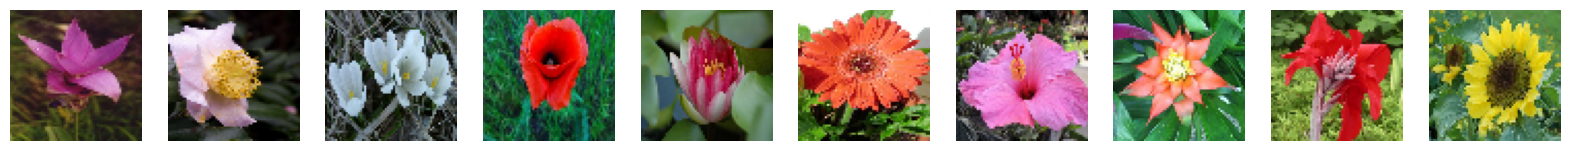

In [6]:
train_sample= sample_batch(train)
display_sample(train_sample)

## DIFFUSION SCHEDULES

In [7]:
T=1000

diffusion_times= tf.convert_to_tensor([x / T for x in range(T)])

(
    linear_noise_rates, 
    linear_signal_rates
)= linear_diffusion_schedule(diffusion_times)

(
    cosine_noise_rates, 
    cosine_signal_rates
)= cosine_diffusion_schedule(diffusion_times)

(
    offset_cos_noise_rates, 
    offset_cos_signal_rates
) = offset_cos_diffusion_schedule(diffusion_times)    
    

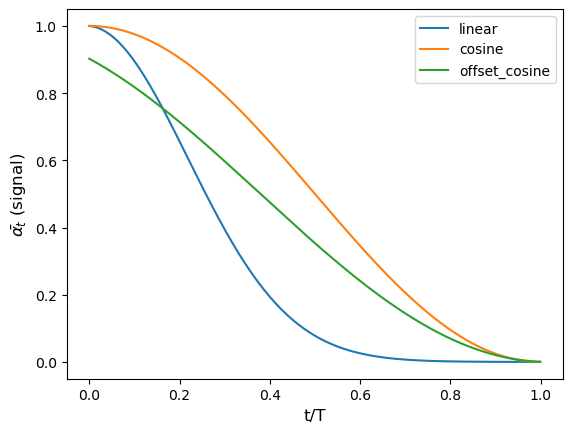

In [8]:
plt.plot(
    diffusion_times,
    linear_signal_rates**2,
    linewidth=1.5,
    label='linear'
)

plt.plot(
    diffusion_times,
    cosine_signal_rates**2,
    linewidth=1.5,
    label='cosine'
)

plt.plot(
    diffusion_times,
    offset_cos_signal_rates**2,
    linewidth=1.5,
    label='offset_cosine'
)

plt.xlabel("t/T",fontsize=12)
plt.ylabel(r"$\bar{\alpha_t}$ (signal)", fontsize=12)
plt.legend()
plt.show()

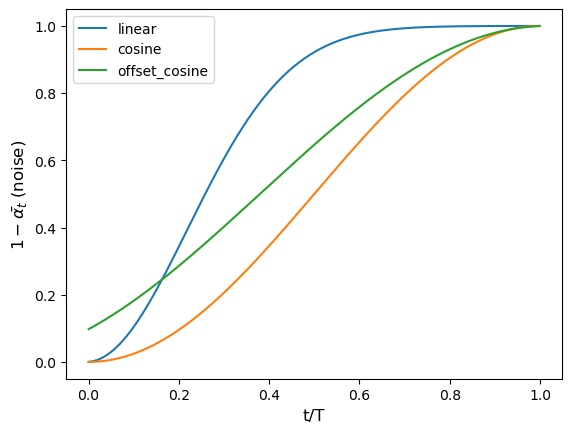

In [9]:
plt.plot(diffusion_times, linear_noise_rates**2,linewidth=1.5, label='linear')
plt.plot(diffusion_times, cosine_noise_rates**2,linewidth=1.5, label='cosine')
plt.plot(diffusion_times, offset_cos_noise_rates**2, linewidth=1.5, label='offset_cosine')

plt.xlabel('t/T', fontsize=12)
plt.ylabel(r'$1-\bar{\alpha_t}$ (noise)', fontsize=12)
plt.legend()
plt.show()

## BUILD MODEL

### Embeddings

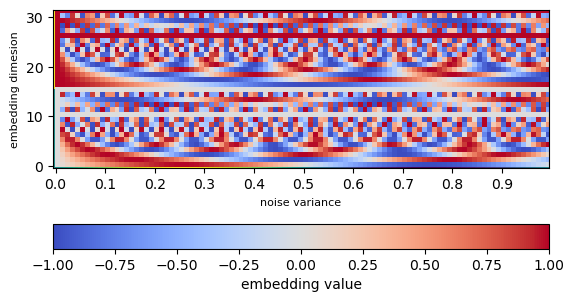

In [10]:
embedding_list= []

for y in np.arange(0,1,.01):
    embedding_list.append(
        sin_embeddings(
            np.array(
                [
                    [
                        [
                            [y]
                        ]
                    ]
                ]
            )
        )[0][0][0]
    )

embedding_array= np.array(np.transpose(embedding_list))

fig, ax= plt.subplots()
ax.set_xticks(
    np.arange(0, 100, 10), labels=np.round(np.arange(.0,1.0,.1), 1)
)

ax.set_ylabel('embedding dimesion', fontsize=8)
ax.set_xlabel('noise variance', fontsize=8)

plt.pcolor(embedding_array, cmap='coolwarm')
plt.colorbar(orientation='horizontal', label='embedding value')

ax.imshow(embedding_array, interpolation='nearest', origin='lower')

plt.show()

### U-NET

In [11]:
noisy_images= layers.Input(shape=(64,64,3))

x= layers.Conv2D(32, kernel_size=1)(noisy_images)

noise_variances= layers.Input(shape=(1,1,1))
noise_embedding= layers.Lambda(sin_embeddings)(noise_variances)
noise_embedding= layers.UpSampling2D(size=64, interpolation='nearest')(noise_embedding)

x= layers.Concatenate()([x, noise_embedding])

skips= []

x= down_block(32, block_depth=2)([x, skips])
x= down_block(64, block_depth=2)([x, skips])
x= down_block(96, block_depth=2)([x, skips])

x= resid_block(128)(x)
x= resid_block(128)(x)

x= up_block(96, block_depth=2)([x, skips])
x= up_block(64, block_depth=2)([x, skips])
x= up_block(32, block_depth=2)([x, skips])

x= layers.Conv2D(3, kernel_size=1, kernel_initializer='zeros')(x)

unet= models.Model([noisy_images, noise_variances], x, name='unet')

In [12]:
unet.summary()

Model: "unet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1, 1, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1, 1, 32)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │        128 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ lambda[0][0]      │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d[0][0],     │
│ (Concatenate)       │ 64)               │            │ up_sampling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        128 │ concatenate[0][0] │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,464 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │      2,080 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64,    │          0 │ conv2d_3[0][0],   │
│                     │ 32)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │         64 │ add[0][0]         │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_4[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 64, 64,    │          0 │ conv2d_5[0][0],   │
│                     │ 32)               │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d   │ (None, 32, 32,    │          0 │ add_1[0][0]       │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ average_pooling2… │
│ (BatchNormalizatio… │ 32)               │            │                 

 Total params: 1,953,507 (7.45 MB)

 Trainable params: 1,950,627 (7.44 MB)

 Non-trainable params: 2,880 (11.25 KB)

### Diffusion Model

In [13]:
class DiffusionModel(models.Model):
    def __init__(self):
        super().__init__()

        self.normalizer= layers.Normalization()
        self.network= unet
        self.ema_network= models.clone_model(self.network)
        self.diffusion_schedule= offset_cos_diffusion_schedule

    def compile(self, **kwargs):
        super().compile(**kwargs)
        self.noise_loss_tracker= metrics.Mean(name='n_loss')

    @property
    def metrics(self):
        return [self.noise_loss_tracker]

    def denormalize(self, images):
        images= self.normalizer.mean + images * self.normalizer.variance**0.5
        return tf.clip_by_value(images, .0, 1.0)

    def denoise(self, noisy_images, noise_rates, signal_rates, training):
        if training:
            network= self.network
        else:
            network= self.ema_network

        pred_noises= network([noisy_images, noise_rates**2], training=training)
        pred_images= (noisy_images - noise_rates * pred_noises) / signal_rates

        return pred_noises, pred_images

    def reverse_diffusion(self, initial_noise, diffusion_steps):
        num_images= initial_noise.shape[0]
        step_size= 1.0 / diffusion_steps
        current_images= initial_noise

        for step in range(diffusion_steps):
            diffusion_times= tf.ones((num_images, 1,1,1)) - step * step_size
            noise_rates, signal_rates= self.diffusion_schedule(diffusion_times)
            pred_noises, pred_images= self.denoise(current_images, noise_rates, signal_rates, training=False)
            next_diffusion_times= diffusion_times - step_size
            next_noise_rates, next_signal_rates= self.diffusion_schedule(next_diffusion_times)
            current_images= (next_signal_rates * pred_images + next_noise_rates * pred_noises)

        return pred_images

    def generate(self, num_images, diffusion_steps, initial_noise=None):
        if initial_noise is None:
            initial_noise= tf.random.normal(shape=(num_images, 64,64,3))

        generated_images= self.reverse_diffusion(initial_noise, diffusion_steps)
        generated_images= self.denormalize(generated_images)

        return generated_images

    def train_step(self, images):
        images= self.normalizer(images, training=True)
        noises= tf.random.normal(shape=(64,64,64,3))

        diffusion_times= tf.random.uniform(shape=(64,1,1,1), minval=.0, maxval=1.0)
        noise_rates, signal_rates= self.diffusion_schedule(diffusion_times)
        noisy_images= signal_rates * images + noise_rates * noises

        with tf.GradientTape() as tape:
            pred_noises, pred_images= self.denoise(noisy_images, noise_rates, signal_rates, training=True)
            noise_loss= self.loss(noises, pred_noises)

        gradients= tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))
        self.noise_loss_tracker.update_state(noise_loss)

        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(.999 * ema_weight + (1 - .999) * weight)

        return { m.name: m.result() for m in self.metrics}

    def test_step(self, images):
        images= self.normalizer(images, training=False)
        noises= tf.random.normal(shape=(64,64,64,3))
        diffusion_times= tf.random.uniform(shape=(64,1,1,1), minval=.0, maxval=1.0)
        noise_rates, signal_rates= self.diffusion_schedule(diffusion_times)
        noisy_images= signal_rates * images + noise_rates * noises
        pred_noises, pred_images= self.denoise(noisy_images, noise_rates, signal_rates, training=False)
        noise_loss= self.loss(noises, pred_noises)
        self.noise_loss_tracker.update_state(noise_loss)

        return {m.name: m.result() for m in self.metrics}
                              
            

In [14]:
%%time
ddim= DiffusionModel()
ddim.normalizer.adapt(train)

CPU times: user 55.9 s, sys: 10.5 s, total: 1min 6s
Wall time: 15.1 s


2024-11-21 21:11:37.214755: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [15]:
LOAD_MODEL= False
if LOAD_MODEL:
    ddim.built= True
    ddim.load_weight('./checkpoints/ddim_flowers_checkpoint.ckpt')

## TRAIN MODEL

### Image Generator

In [16]:
class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img= num_img

    def on_epoch_end(self, epoch, logs=None):
        generated_images= self.model.generate(num_images=self.num_img, diffusion_steps=20).numpy()
        display_sample(generated_images)

### Callbacks

In [17]:
model_checkpoint_callback= callbacks.ModelCheckpoint(
    filepath= checkpoint_dir + 'checkpoint.weights.h5',
    save_weights_only=True,
    save_freq='epoch',
    verbose=0
)

tensorboard_callback= callbacks.TensorBoard(log_dir=tensorboard_log_dir)

image_generator_callback= ImageGenerator(num_img=10)

### Compile

In [18]:
ddim.compile(  
    optimizer=optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4),
    loss=losses.mae
)

### Fit

Epoch 1/60


2024-11-21 21:11:45.091282: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-21 21:11:45.776179: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


639/639 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - n_loss: 0.2962

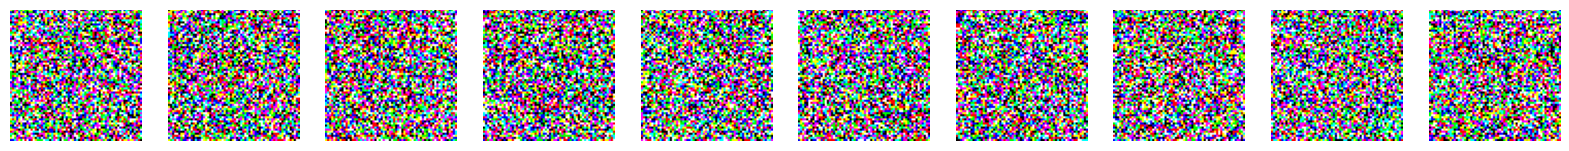

639/639 ━━━━━━━━━━━━━━━━━━━━ 432s 625ms/step - n_loss: 0.2961
Epoch 2/60
639/639 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - n_loss: 0.1965

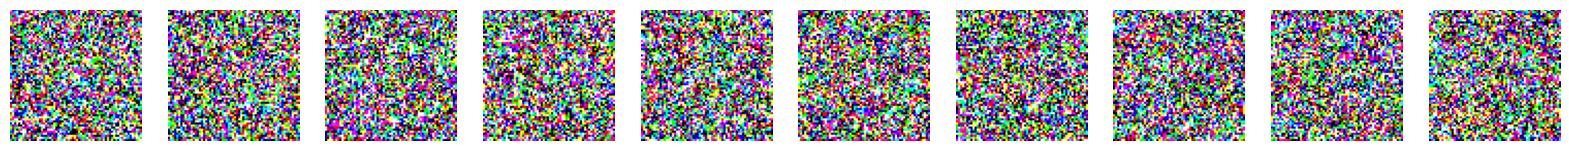

639/639 ━━━━━━━━━━━━━━━━━━━━ 657s 1s/step - n_loss: 0.1964
Epoch 3/60
639/639 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - n_loss: 0.1917

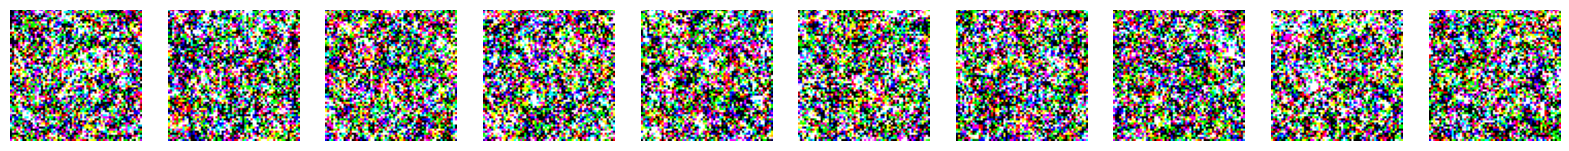

639/639 ━━━━━━━━━━━━━━━━━━━━ 657s 1s/step - n_loss: 0.1917
Epoch 4/60
639/639 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - n_loss: 0.1860

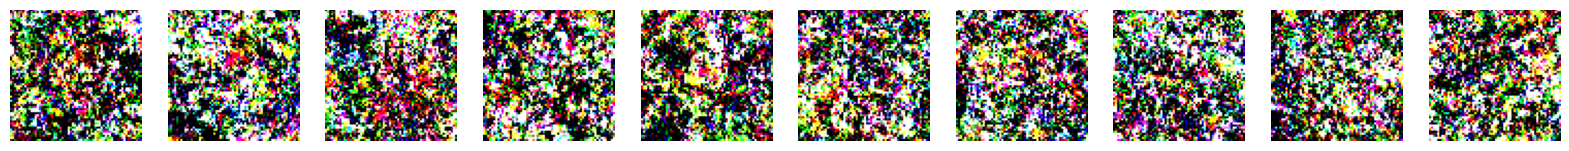

639/639 ━━━━━━━━━━━━━━━━━━━━ 657s 1s/step - n_loss: 0.1860
Epoch 5/60
639/639 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - n_loss: 0.1835

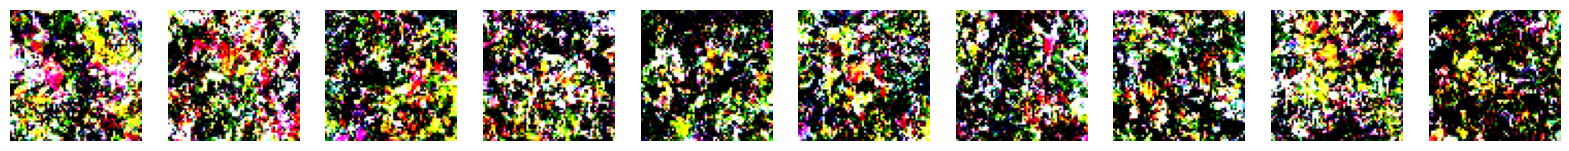

639/639 ━━━━━━━━━━━━━━━━━━━━ 657s 1s/step - n_loss: 0.1835
Epoch 6/60
639/639 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - n_loss: 0.1825

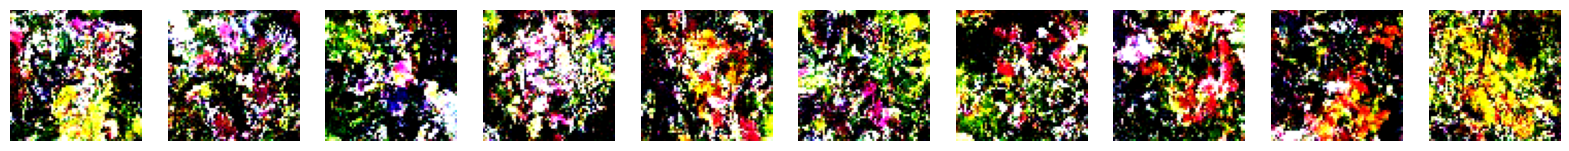

639/639 ━━━━━━━━━━━━━━━━━━━━ 659s 1s/step - n_loss: 0.1825
Epoch 7/60
639/639 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - n_loss: 0.1812

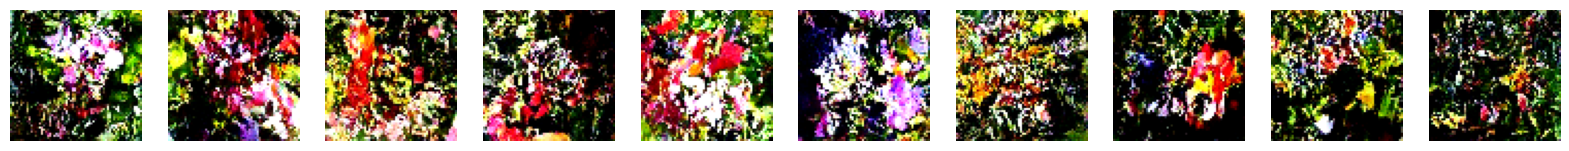

639/639 ━━━━━━━━━━━━━━━━━━━━ 656s 1s/step - n_loss: 0.1812
Epoch 8/60
639/639 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - n_loss: 0.1795

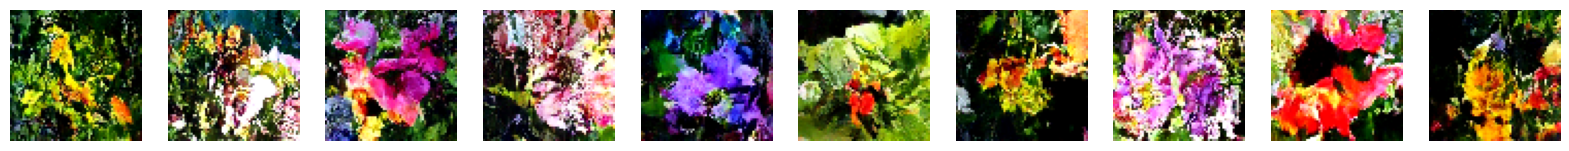

639/639 ━━━━━━━━━━━━━━━━━━━━ 326s 510ms/step - n_loss: 0.1795
Epoch 9/60
639/639 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - n_loss: 0.1784

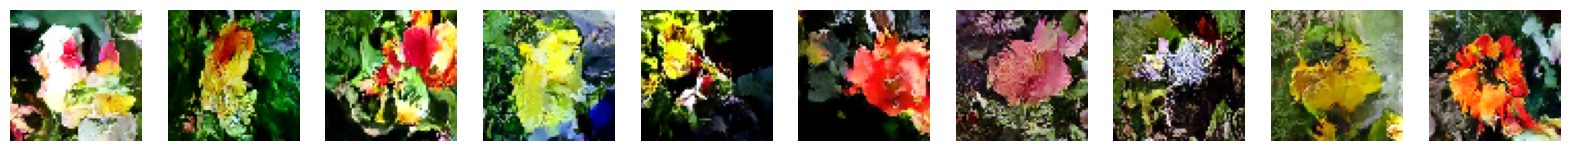

639/639 ━━━━━━━━━━━━━━━━━━━━ 168s 263ms/step - n_loss: 0.1784
Epoch 10/60
639/639 ━━━━━━━━━━━━━━━━━━━━ 0s 809ms/step - n_loss: 0.1783

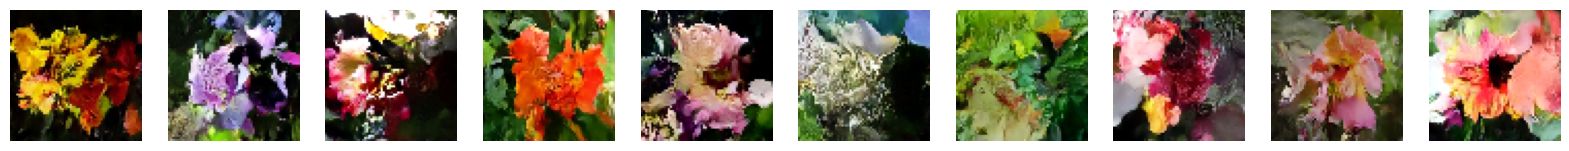

639/639 ━━━━━━━━━━━━━━━━━━━━ 520s 814ms/step - n_loss: 0.1783
Epoch 11/60
639/639 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - n_loss: 0.1771

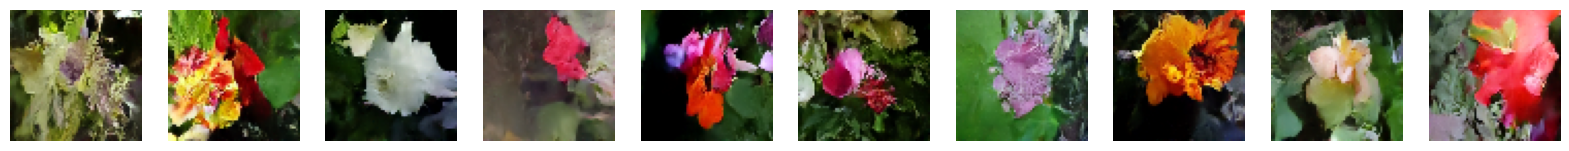

639/639 ━━━━━━━━━━━━━━━━━━━━ 656s 1s/step - n_loss: 0.1771
Epoch 12/60
639/639 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - n_loss: 0.1770

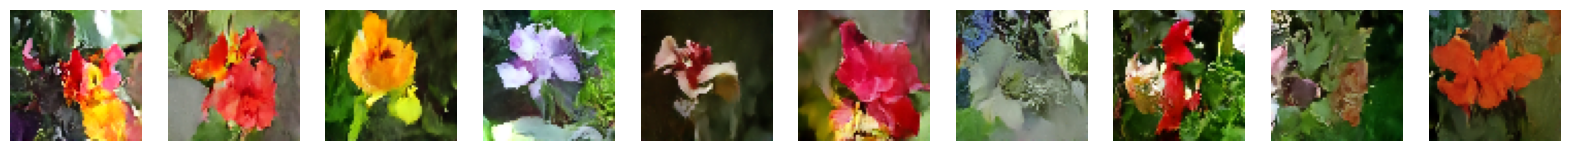

639/639 ━━━━━━━━━━━━━━━━━━━━ 656s 1s/step - n_loss: 0.1770
Epoch 13/60
639/639 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - n_loss: 0.1769

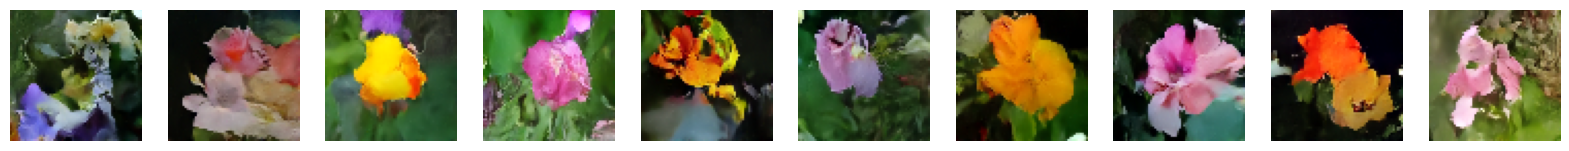

639/639 ━━━━━━━━━━━━━━━━━━━━ 657s 1s/step - n_loss: 0.1769
Epoch 14/60
639/639 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - n_loss: 0.1761

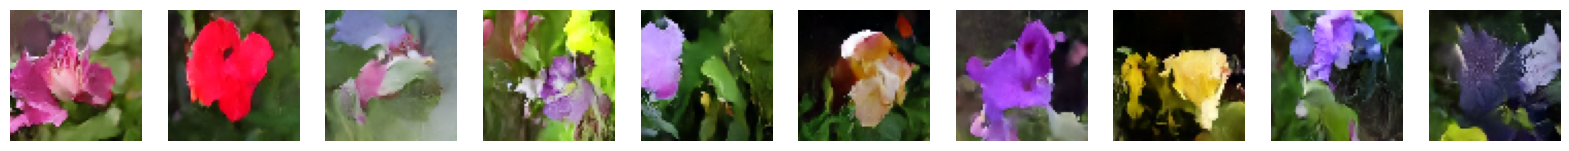

639/639 ━━━━━━━━━━━━━━━━━━━━ 656s 1s/step - n_loss: 0.1761
Epoch 15/60
639/639 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - n_loss: 0.1761

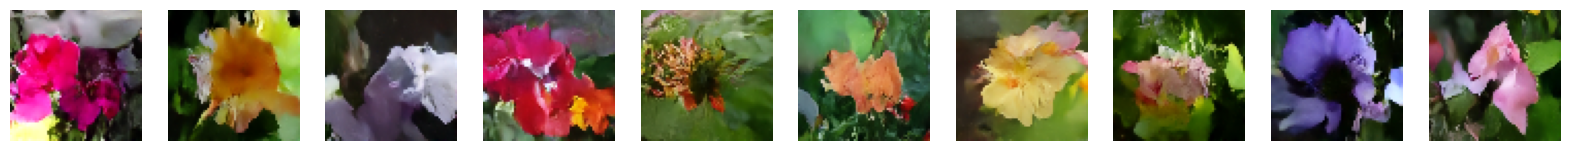

639/639 ━━━━━━━━━━━━━━━━━━━━ 656s 1s/step - n_loss: 0.1761
Epoch 16/60
222/639 ━━━━━━━━━━━━━━━━━━━━ 7:06 1s/step - n_loss: 0.1755

In [ ]:
ddim.fit(
    train,
    epochs=60,
    callbacks= [
        model_checkpoint_callback,
        tensorboard_callback,
        image_generator_callback
    ]    
)

### INFERENCE

In [ ]:
# Generate same novel images of flowers
generated_images= ddim.generate(num_images=10, diffusion_steps=20).numpy()
display_sample(generated_images)

In [ ]:
# View improvement over greater number of diffusion steps
for diffusion_steps in list(np.arange(1,6,1)) + [20] + [100]:
    tf.random.set_seed(42)
    generated_images= ddim.generated_images= ddim.generate(num_images=10, diffusion_steps=diffusion_steps).numpy()
    display_sample(generated_images)

In [ ]:
# Interpolation between two points in same latent space
tf.random.set_seed(100)

for i in range(5):
    a= tf.random.normal(shape=(64,64,3))
    b= tf.random.normal(shape=(64,63,3))

    initial_noise= np.array([spherical_interpolation(a,b,t) for t in np.arange(0,1.1,.1)])
    generated_images= ddim.generate(num_images=2, diffusion_steps=20, initial_noise=initial_noise).numpy()

    display_sample(generated_images)

https://www.youtube.com/watch?v=HoKDTa5jHvg
https://www.youtube.com/watch?v=B4oHJpEJBAA